# SIT742: Modern Data Science 

**Project Information:**

- Names: Ishaan Bazaz

---

# 1.Import Spark

In [0]:
!pip install wget
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
!tar xf spark-2.4.0-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"


In [0]:
!pip install pyspark
from pyspark import SparkContext
sc = SparkContext.getOrCreate()
import findspark
findspark.init()
from pyspark.sql import SparkSession 
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
sqlContext

# 2.Read and check data

In [0]:
# Import the 'bank.csv' as a Spark dataframe and name it as df
import wget
dataset = wget.download('https://github.com/tulip-lab/sit742/raw/master/Assessment/2019/data/bank.csv')
spark = SparkSession.builder.appName('ml-bank').getOrCreate()
df = spark.read.csv(dataset, header = True, inferSchema = True) 

In [0]:
# Check data distribution
# You may use printSchema()
df.printSchema() 

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



# 3.Select features

In [0]:
#Select features ('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit') as df2
df2 = df.select('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit')

In [0]:
#Remove invalid rows/records using spark.sql 
filtered_df = df2.filter(~(df2.job.isin('unknown') | df2.education.isin('unknown') | df2.poutcome.isin('unknown') | df2.poutcome.isin('other')))
filtered_df.show()
filtered_df.count()

+---+------------+--------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+
|age|         job| marital|education|default|balance|housing|loan|campaign|pdays|previous|poutcome|deposit|
+---+------------+--------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+
| 33|    services| married|secondary|     no|   3444|    yes|  no|       1|   91|       4| failure|    yes|
| 56|  technician| married|secondary|     no|    589|    yes|  no|       1|  147|       2| success|    yes|
| 34|      admin.| married| tertiary|     no|    899|    yes|  no|       1|  170|       3| failure|    yes|
| 53|     retired| married| tertiary|     no|   2269|     no|  no|       2|  150|       1| success|    yes|
| 37|  technician| married|secondary|     no|   5115|    yes|  no|       2|  171|       4| failure|    yes|
| 45|entrepreneur| married|secondary|     no|    781|     no| yes|       2|  126|       2| failure|    yes|
| 46|  unemployed|divorced|s

2181

In [0]:
#Covert categorical features to metric features using One hot encoding
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'poutcome']
cols=filtered_df.columns
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'balance', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(filtered_df)
ohe_df = pipelineModel.transform(filtered_df)
selectedCols = ['label', 'features'] + cols
ohe_df = ohe_df.select(selectedCols)

In [0]:
import pandas as pd
pd.DataFrame(ohe_df.take(20), columns=ohe_df.columns).transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
label,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
features,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
age,33,56,34,53,37,45,46,40,32,30,46,38,32,31,50,47,59,31,53,40
job,services,technician,admin.,retired,technician,entrepreneur,unemployed,management,technician,blue-collar,technician,entrepreneur,services,unemployed,blue-collar,technician,management,management,blue-collar,technician
marital,married,married,married,married,married,married,divorced,married,married,married,married,married,married,married,married,married,married,married,married,single
education,secondary,secondary,tertiary,tertiary,secondary,secondary,secondary,tertiary,tertiary,secondary,tertiary,tertiary,secondary,secondary,primary,secondary,tertiary,secondary,secondary,tertiary
default,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no
balance,3444,589,899,2269,5115,781,3354,3352,4654,501,0,1110,983,314,12519,0,7049,8629,1777,1646
housing,yes,yes,yes,no,yes,no,yes,yes,yes,yes,no,yes,yes,yes,yes,no,no,yes,yes,yes
loan,no,no,no,no,no,yes,no,no,yes,yes,no,no,no,no,no,no,no,no,no,no


## 3.1 normalisation

In [0]:
#Apply Min-Max normalisation on each attribute using MinMaxScaler  
from pyspark.ml.feature import MinMaxScaler  
scaled_df = MinMaxScaler(inputCol="features", outputCol="scaled_features").fit(ohe_df).transform(ohe_df)

In [0]:
scaled_df.show()

+-----+--------------------+---+------------+--------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+--------------------+
|label|            features|age|         job| marital|education|default|balance|housing|loan|campaign|pdays|previous|poutcome|deposit|     scaled_features|
+-----+--------------------+---+------------+--------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+--------------------+
|  0.0|(23,[5,10,12,14,1...| 33|    services| married|secondary|     no|   3444|    yes|  no|       1|   91|       4| failure|    yes|[0.0,0.0,0.0,0.0,...|
|  0.0|(23,[1,10,12,14,1...| 56|  technician| married|secondary|     no|    589|    yes|  no|       1|  147|       2| success|    yes|[0.0,1.0,0.0,0.0,...|
|  0.0|(23,[2,10,13,14,1...| 34|      admin.| married| tertiary|     no|    899|    yes|  no|       1|  170|       3| failure|    yes|[0.0,0.0,1.0,0.0,...|
|  0.0|(23,[4,10,13,14,1...| 53|     retired| married| tertiary|

# 4.Unsupervised learning

## 4.1 K-means

In [0]:
# Perform unsupervised learning on df2 with k-means 
# You can use whole df2 as both training and testing data, 
# Evaluate the clustering result using Accuracy.  
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator 

kmeans = KMeans().setK(2)
model = kmeans.fit(scaled_df)
predictions = model.transform(scaled_df)
print("silhouette value " + str(ClusteringEvaluator().evaluate(predictions)))

silhouette value 0.9186436591342558


## 4.2 PCA

In [0]:
#Generate a scatter plot using the first two PCA components to investigate the data distribution.
from pyspark.ml.feature import PCA
pca = PCA(k=2, inputCol="scaled_features", outputCol="pca_features")
output = pca.fit(scaled_df).transform(scaled_df).select("pca_features")

In [0]:
output.show()

+--------------------+
|        pca_features|
+--------------------+
|[0.96364248505160...|
|[0.83734101836268...|
|[-0.1084500265257...|
|[-0.4795609426700...|
|[0.95767948650617...|
|[0.78790279189690...|
|[0.51243046926688...|
|[-0.7369547765884...|
|[-0.1028260652716...|
|[1.06615145941459...|
|[-0.3247429463401...|
|[-0.2109752165189...|
|[0.96439157020120...|
|[0.89700320059017...|
|[0.47244006359864...|
|[0.78408608927661...|
|[-0.7640855001185...|
|[0.50781947141051...|
|[1.02098210832885...|
|[-0.6823665987365...|
+--------------------+
only showing top 20 rows



In [0]:
res = output.toPandas()
res

,pca_features
0,"[0.9636424850516068, 0.3313811478935345]"
1,"[0.8373410183626885, 0.3880024159205323]"
2,"[-0.10845002652578276, 0.6564023408615134]"
3,"[-0.479560942670008, 1.1082617061107987]"
4,"[0.9576794865061756, 0.2714643678687506]"
5,"[0.7879027918969023, 0.5145147352059565]"
6,"[0.5124304692668866, -0.1917648708243116]"
7,"[-0.7369547765884317, 1.0356901001261056]"
8,"[-0.10282606527163515, 0.671822806010155]"
9,"[1.0661514594145962, 0.3285042864447201]"


In [0]:
import numpy
pca1=[]
pca2=[]
for i in range (2181):
  pca1 = numpy.append (pca1, res.iloc[i,0][0])

for i in range (2181):
  pca2 = numpy.append (pca2, res.iloc[i,0][1])
  

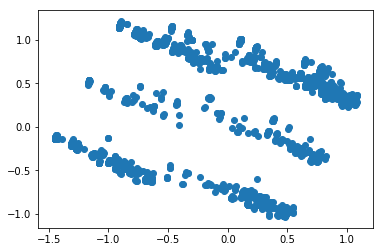

In [0]:
import matplotlib.pyplot as pl
pl.scatter(pca1, pca2)

# 5.Supervised learning

In [0]:
train, test = scaled_df.randomSplit([0.7, 0.3])

## 5.1 LogisticRegression

In [0]:
# Logistic Regression
from pyspark.ml.classification import LogisticRegression 
lr = LogisticRegression(featuresCol='scaled_features', labelCol ='label', maxIter=5)
lrModel = lr.fit(train)
predictions = lrModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability')

DataFrame[age: int, job: string, label: double, rawPrediction: vector, prediction: double, probability: vector]

In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator 
print('accuracy ',MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName="accuracy").evaluate(predictions))


accuracy  0.7545454545454545


## 5.2 Decision tree

In [0]:
#Decision tree
from pyspark.ml.classification import DecisionTreeClassifier 
dt = DecisionTreeClassifier(featuresCol='scaled_features', labelCol ='label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('age', 'job','label', 'rawPrediction', 'prediction', 'probability')

DataFrame[age: int, job: string, label: double, rawPrediction: vector, prediction: double, probability: vector]

In [0]:
print('accuracy ',MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName="accuracy").evaluate(predictions))

accuracy  0.7696969696969697


## 5.3 NaiveBayes

In [0]:
#NaiveBayes
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(featuresCol='scaled_features', labelCol ='label', smoothing=1)
model = nb.fit(train)

predictions = model.transform(test)
predictions.filter(predictions['prediction'] == 0) \
    .select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability') \
    .orderBy("probability", ascending=False)

DataFrame[age: int, job: string, label: double, rawPrediction: vector, prediction: double, probability: vector]

In [0]:
print('accuracy ',MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName="accuracy").evaluate(predictions))

accuracy  0.7378787878787879
